In [1]:
import os
import cmdstanpy
from cmdstanpy import CmdStanModel
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import describe, gaussian_kde, norm
import multiprocessing
import seaborn as sns
import warnings
import time

In [2]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 8]
plt.rcParams['font.size'] = 14

In [3]:
from thinning import sample_hawkes_process_thinning_true_vectorised
from utils import exp_kernel_vectorised, constant_background, plot_counting_process
from mle import log_likelihood

In [4]:
np.random.SeedSequence()

SeedSequence(
    entropy=262204985315174550286103675232346159014,
)

In [34]:
def trace_plots(fits, params, warmup=None, chains=2):
    n = len(fits)
    m = len(params)
    max_y = np.zeros(m)
    fig, axs = plt.subplots(nrows=n, ncols=m, figsize=(5*m, 3*n))
    for i in range(n):
        df = fits[i].draws_pd(inc_warmup=(warmup is not None))
        for j in range(m):
            for k in range(1, chains+1):
                axs_temp = axs[i] if m==1 else axs[i, j]
                axs_temp.plot(df[df['chain__']==k][params[j]].values, label=k)
            if warmup:
                axs_temp.axvspan(xmin=0, xmax=warmup, color='gray', alpha=0.3, label='warmup')
            #axs[i, j].legend()
            max_y[j] = max(max(df[df['chain__']==k][params[j]].values), max_y[j])
            if i==0:
                axs_temp.set_title(params[j])

    for i in range(n):
        for j in range(m):
            axs_temp = axs[i] if m==1 else axs[i, j]
            axs_temp.set_ylim(0, max_y[j])

    an_axs = axs[0] if m==1 else axs[0, 0]
    handles, labels = an_axs.get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.01), ncol=chains+1)
    
    plt.tight_layout()
    plt.show()

In [16]:
def posterior_histograms(fits, params, prior_functions=None):
    n = len(fits)
    m = len(params)
    fig, axs = plt.subplots(nrows=n, ncols=m, figsize=(5*m, 3*n))
    max_x = np.zeros(m)
    max_y = np.zeros(m)
    
    # Plot histograms and KDE plots for posterior distributions
    for i in range(n):
        df = fits[i].draws_pd()
        for j in range(m):
            data = df[params[j]].values
            hist, bins, _ = axs[i, j].hist(data, density=True, alpha=0.5, bins=30, color='blue')  # Plot histogram
            
            # Suppress specific future warning
            with warnings.catch_warnings():
                warnings.simplefilter(action='ignore', category=FutureWarning)
                sns.kdeplot(data, color='blue', ax=axs[i, j], label='Posterior KDE')  # Overlay KDE plot on histogram

            credible_interval = stats.mstats.mquantiles(data, [0.025, 0.975])
            axs[i, j].axvspan(xmin=credible_interval[0], xmax=credible_interval[1], color='green', alpha=0.2, label='95% CI')

            max_x[j] = max(max_x[j], max(data))
            max_y[j] = max(max_y[j], max(hist))
            
            if i == 0:
                axs[i, j].set_title(params[j])  # Set title for the first row of subplots

    # Set the same limits for all subplots
    for i in range(n):
        for j in range(m):
            axs[i, j].set_xlim(0, max_x[j])
            axs[i, j].set_ylim(0, max_y[j])


    # Optionally plot prior density functions
    if prior_functions is not None:
        for j, prior_func in enumerate(prior_functions):
            for i, ax_row in enumerate(axs):
                x_values = np.linspace(0, max_x[j], 1000)  # Generate x values for prior function evaluation
                prior_values = prior_func(x_values)  # Evaluate prior density function
                ax_row[j].plot(x_values, prior_values, color='red', linestyle='--', label='Prior')  # Overlay prior distribution
    
    handles, labels = axs[0, 0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.01), ncol=m)
    
    plt.tight_layout()
    plt.show()

In [18]:
def posterior_kdes_overlaid(fits, params, prior_functions=None):
    n = len(fits)
    m = len(params)
    fig, axs = plt.subplots(nrows=1, ncols=m, figsize=(5*m, 3))
    max_x = np.zeros(m)

    for i in range(n):
        df = fits[i].draws_pd()
        for j in range(m):
            data = df[params[j]].values
            # Suppress specific future warning
            with warnings.catch_warnings():
                warnings.simplefilter(action='ignore', category=FutureWarning)
                sns.kdeplot(data, ax=axs[j], alpha=0.5)

            if i == 0:
                axs[j].set_title(params[j])
            max_x[j] = max(max(data), max_x[j])

    # Optionally plot prior density functions
    if prior_functions is not None:
        for j, prior_func in enumerate(prior_functions):
            x_values = np.linspace(0, max_x[j], 1000)  # Generate x values for prior function evaluation
            prior_values = prior_func(x_values)  # Evaluate prior density function
            axs[j].plot(x_values, prior_values, color='red', linestyle='--', label='Prior')  # Overlay prior distribution

        handles, labels = axs[0].get_legend_handles_labels()
        fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=m)
    
    plt.tight_layout()
    plt.show()

## Now we compare fixing alpha and mu on runtime

First without fixing

In [5]:
max_T = 300
num_samples = 3
hawkes_realisations = []

master_seed = 240918493712496904598658578838980943694
seed_seq_master = np.random.SeedSequence(master_seed)

for i in range(num_samples):

    child_seed = seed_seq_master.spawn(1)[0]

    hawkes_realisation = sample_hawkes_process_thinning_true_vectorised(max_T, constant_background, exp_kernel_vectorised, seed=child_seed)
    hawkes_realisations.append(hawkes_realisation)

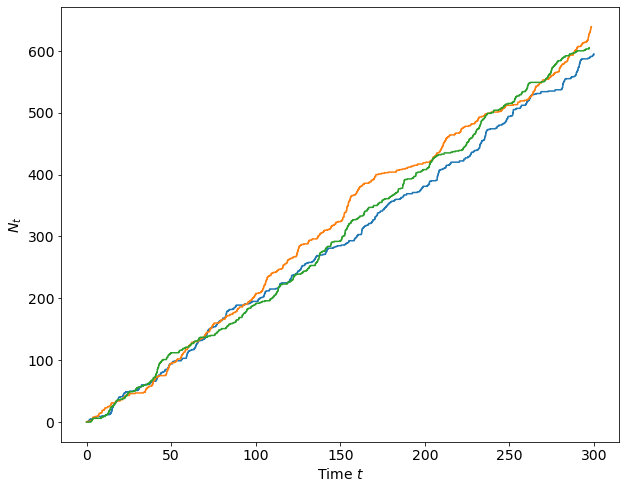

In [6]:
for h in hawkes_realisations:
    h = [0] + h
    counts = np.arange(len(h))
    plt.step(h, counts, where='post')
plt.xlabel("Time $t$")
plt.ylabel("$N_t$")
plt.show()

In [7]:
max_T_vals = [100, 200, 300]

data_lists = []

for i, T in enumerate(max_T_vals):
    data_list = []
    for j, realisation in enumerate(hawkes_realisations):
        index = np.searchsorted(realisation, T)
        h = realisation[:index]
        data_list.append({
            "N" : len(h),
            "events_list" : h,
            "max_T" : T})
    data_lists.append(data_list)

# data_lists[i] corresponds to max_T_vals[i]
# data_lists[i][j] corresponds to max_T_vals[i], hawkes_realisation[j]

In [8]:
stan_file = os.path.join('.', 'simple_exp_hawkes_v2_nonneg_mu.stan')
model_compiled = CmdStanModel(stan_file=stan_file,
                                # If you want multi-thread option, need to recompile
                                cpp_options={'STAN_THREADS': 'TRUE'},
                                # turn off below to avoid recompiling
                                # force_compile=True
                                )

In [9]:
model_compiled.exe_info()

{'stan_version_major': '2',
 'stan_version_minor': '34',
 'stan_version_patch': '1',
 'STAN_THREADS': 'true',
 'STAN_MPI': 'false',
 'STAN_OPENCL': 'false',
 'STAN_NO_RANGE_CHECKS': 'false',
 'STAN_CPP_OPTIMS': 'false'}

In [10]:
warmup=250

master_seed_stan = 326671534408189701061260384674174489304
seed_seq_master_stan = np.random.SeedSequence(master_seed_stan)

fits_list = []

for i, T in enumerate(max_T_vals): 
    print(f"max_T={T}")
    fits = []
    for j in range(num_samples):
        print(f"Sample no. {j}")

        child_seed_stan = seed_seq_master_stan.spawn(1)[0]
    
        # Create a random number generator using the seed
        rng = np.random.default_rng(child_seed_stan)
        
        # Generate random integers less than 2**32 - 1
        child_seed = rng.integers(2**32 - 1)
        print(child_seed)

        start = time.time()
        fit = model_compiled.sample(data=data_lists[i][j],
                                    seed=child_seed,
                                    chains=2,
                                    parallel_chains=2,
                                    iter_warmup=warmup,
                                    iter_sampling=3*warmup,
                                    inits="0",
                                    save_warmup=True)
        end = time.time()
        print(f"Model took {end-start} seconds")
        fits.append(fit)
    fits_list.append(fits)

17:05:35 - cmdstanpy - INFO - CmdStan start processing


max_T=100
Sample no. 0
2667290524


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

17:06:01 - cmdstanpy - INFO - CmdStan done processing.
17:06:01 - cmdstanpy - INFO - CmdStan start processing



Model took 26.27984642982483 seconds
Sample no. 1
887231202


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

17:06:31 - cmdstanpy - INFO - CmdStan done processing.
17:06:31 - cmdstanpy - INFO - CmdStan start processing



Model took 30.305376529693604 seconds
Sample no. 2
1466395129


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

17:06:59 - cmdstanpy - INFO - CmdStan done processing.
17:06:59 - cmdstanpy - INFO - CmdStan start processing



Model took 27.515993118286133 seconds
max_T=200
Sample no. 0
3901587029


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

17:09:06 - cmdstanpy - INFO - CmdStan done processing.
17:09:06 - cmdstanpy - INFO - CmdStan start processing



Model took 127.75833368301392 seconds
Sample no. 1
1047072621


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

17:11:40 - cmdstanpy - INFO - CmdStan done processing.
17:11:40 - cmdstanpy - INFO - CmdStan start processing



Model took 153.78211951255798 seconds
Sample no. 2
713739383


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

17:14:01 - cmdstanpy - INFO - CmdStan done processing.


17:14:01 - cmdstanpy - INFO - CmdStan start processing


Model took 140.75935888290405 seconds
max_T=300
Sample no. 0
4127635419


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

17:18:33 - cmdstanpy - INFO - CmdStan done processing.
17:18:33 - cmdstanpy - INFO - CmdStan start processing



Model took 271.81699323654175 seconds
Sample no. 1
3485407414


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

17:24:57 - cmdstanpy - INFO - CmdStan done processing.
17:24:57 - cmdstanpy - INFO - CmdStan start processing



Model took 383.7801556587219 seconds
Sample no. 2
3956522181


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

17:39:49 - cmdstanpy - INFO - CmdStan done processing.



Model took 892.4889154434204 seconds


In [22]:
save_path = r"C:\Users\ethan\OneDrive - University of Bristol\Maths\Year 4\Project\hawkes_project\bayesian\fixed_nonfixed_comparison_21april\nonfixed"

In [23]:
for i,T in enumerate(max_T_vals):
    for j in range(num_samples):
        fits_list[i][j].save_csvfiles(os.path.join(save_path, f"fit_max_T={T}_sample={j}"))

In [13]:
for i in range(3):
    for j in range(num_samples):
        print(fits_list[i][j].summary())
        print(fits_list[i][j].diagnose())

                            Mean      MCSE  ...  N_Eff/s     R_hat
lp__                  -43.125100  0.047795  ...  17.4197  0.999364
mu                      0.969665  0.005861  ...  25.0001  0.999631
alpha                   1.079200  0.009702  ...  17.6606  1.004410
delta                   2.141510  0.020812  ...  17.2297  1.002610
hawkes_log_likelihood -43.672800  0.040802  ...  19.1571  0.999809

[5 rows x 9 columns]
Processing csv files: C:\Users\ethan\AppData\Local\Temp\tmp5ok4goz_\simple_exp_hawkes_v2_nonneg_mup4t0703h\simple_exp_hawkes_v2_nonneg_mu-20240421170535_1.csvWarning: non-fatal error reading adaptation data
, C:\Users\ethan\AppData\Local\Temp\tmp5ok4goz_\simple_exp_hawkes_v2_nonneg_mup4t0703h\simple_exp_hawkes_v2_nonneg_mu-20240421170535_2.csvWarning: non-fatal error reading adaptation data


Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI 

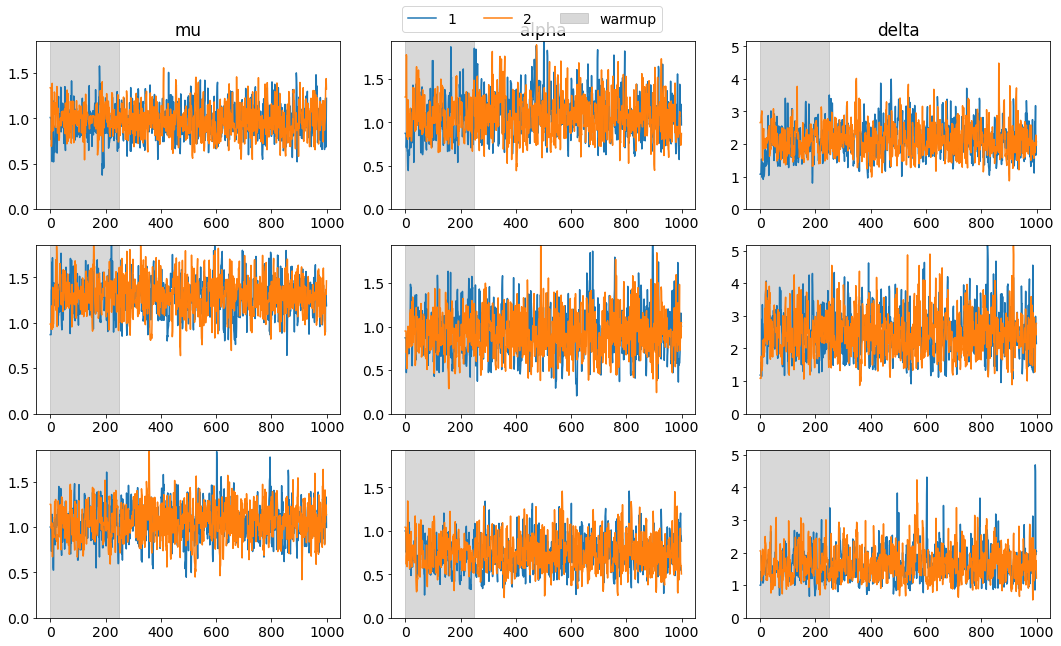

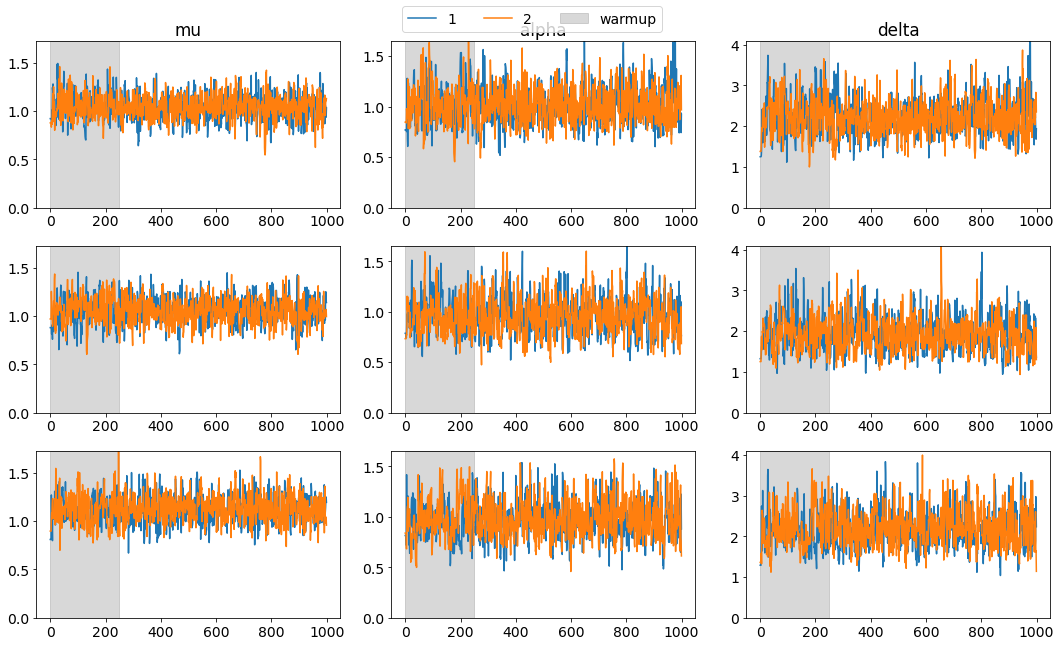

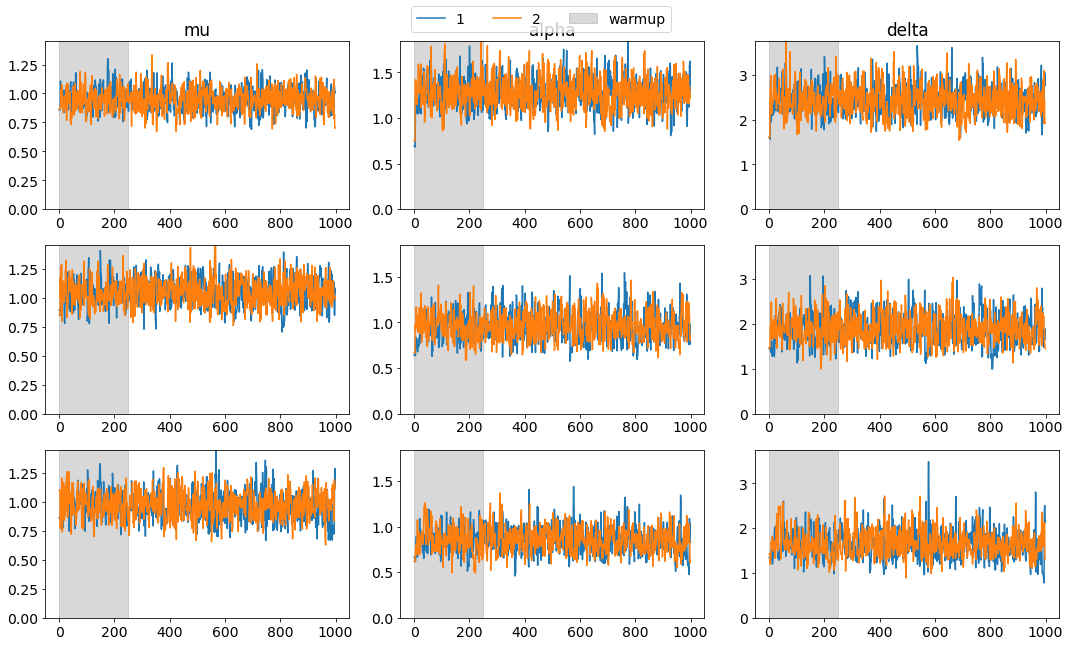

In [15]:
for i in range(3):
    trace_plots(fits_list[i], ['mu', 'alpha', 'delta'], warmup=warmup)

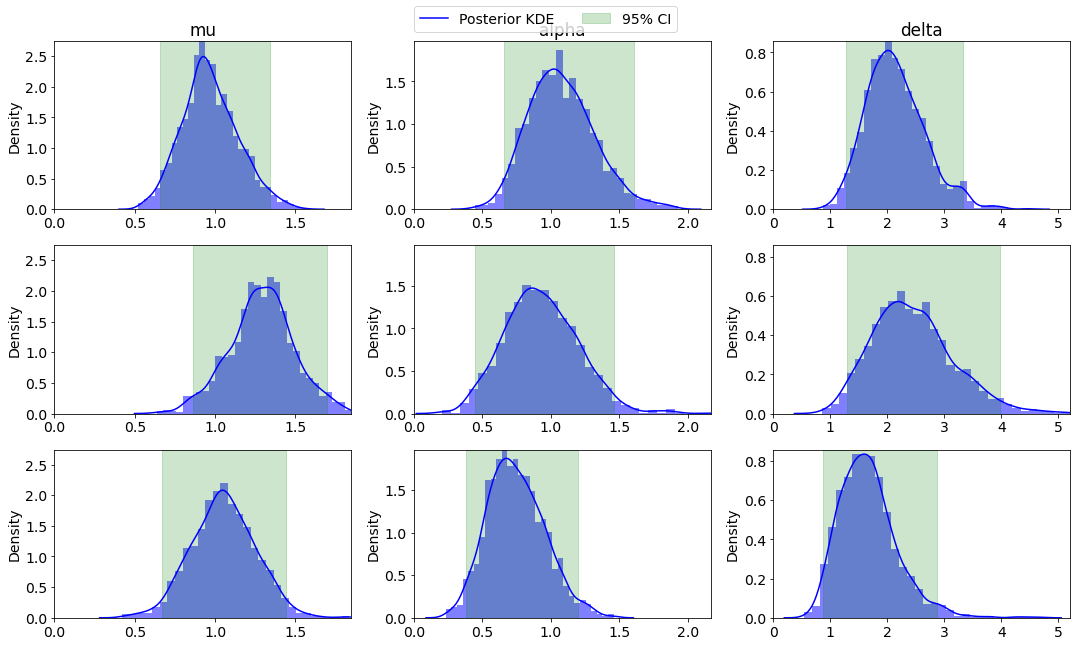

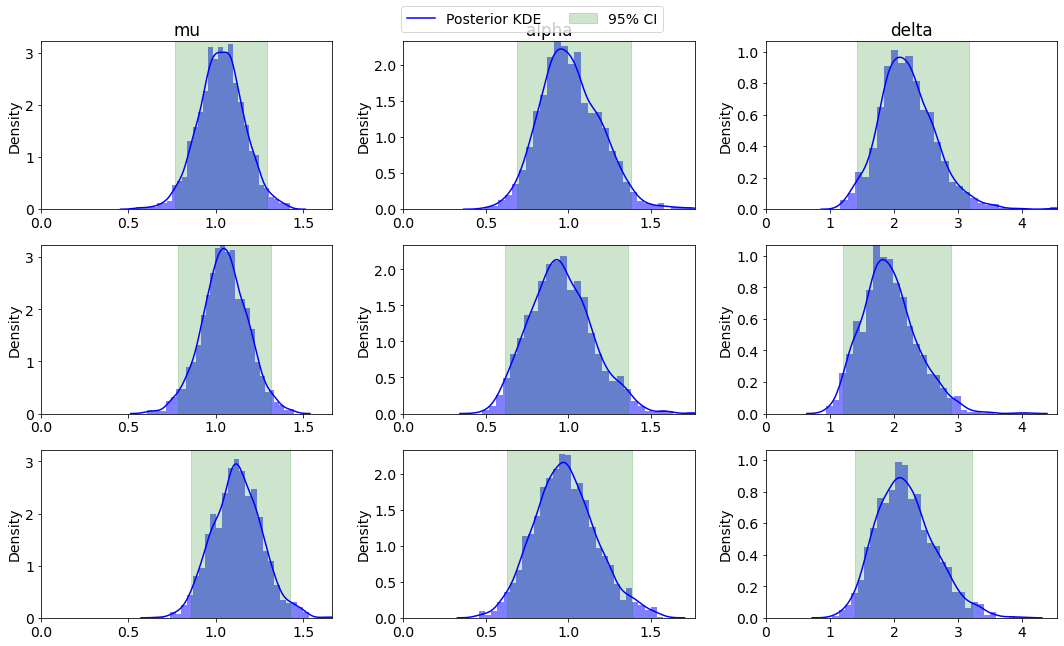

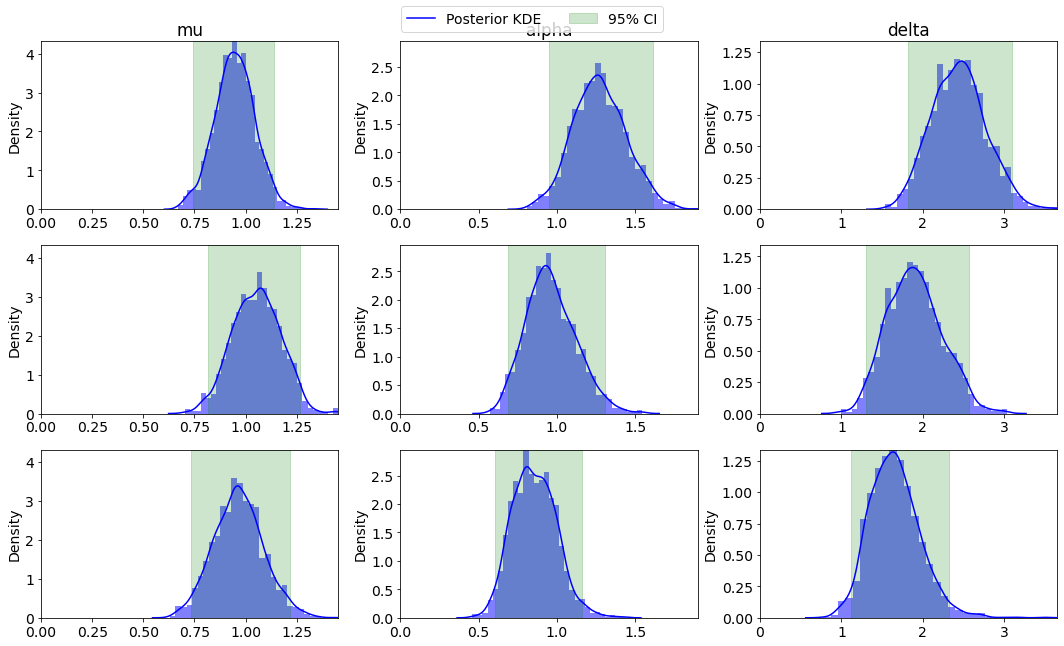

In [17]:
for i in range(3):
    posterior_histograms(fits_list[i], ['mu', 'alpha', 'delta'])

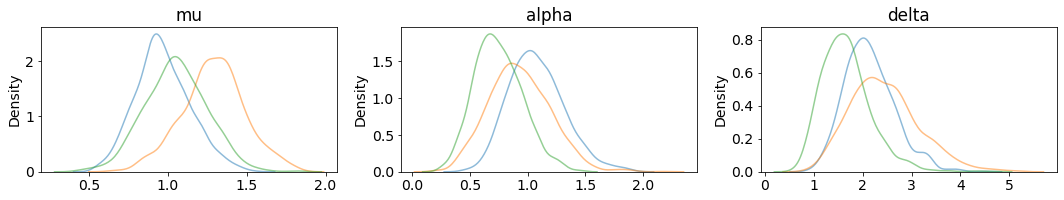

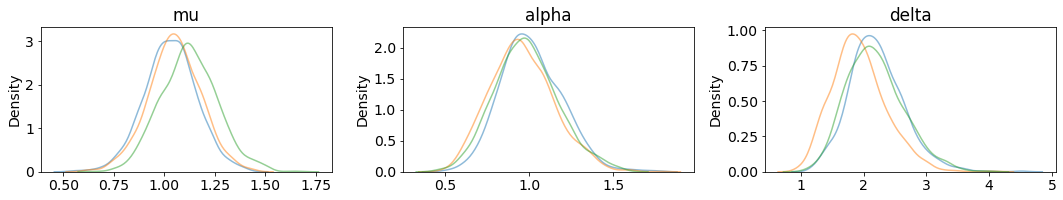

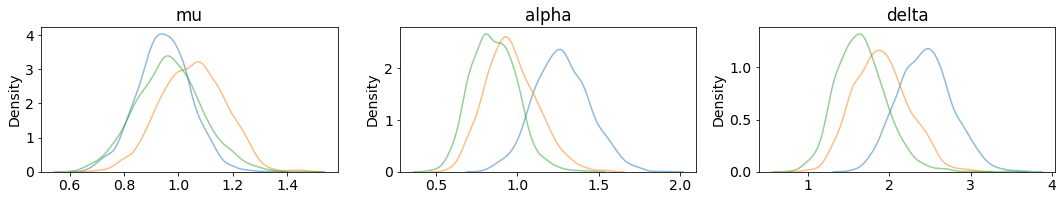

In [19]:
for i in range(3):
    posterior_kdes_overlaid(fits_list[i], ['mu', 'alpha', 'delta'])

Now for alpha, mu fixed.

In [27]:
stan_file = os.path.join('.', 'simple_exp_hawkes_v2_fixed_mu_alpha.stan')
model_compiled = CmdStanModel(stan_file=stan_file,
                                # If you want multi-thread option, need to recompile
                                cpp_options={'STAN_THREADS': 'TRUE'},
                                # turn off below to avoid recompiling
                                # force_compile=True
                                )

17:52:24 - cmdstanpy - INFO - compiling stan file C:\Users\ethan\ONEDRI~1\Maths\YEAR4~1\Project\HAWKES~1\simple_exp_hawkes_v2_fixed_mu_alpha.stan to exe file C:\Users\ethan\OneDrive - University of Bristol\Maths\Year 4\Project\hawkes_project\simple_exp_hawkes_v2_fixed_mu_alpha.exe
17:52:42 - cmdstanpy - INFO - compiled model executable: C:\Users\ethan\OneDrive - University of Bristol\Maths\Year 4\Project\hawkes_project\simple_exp_hawkes_v2_fixed_mu_alpha.exe


In [28]:
model_compiled.exe_info()

{'stan_version_major': '2',
 'stan_version_minor': '34',
 'stan_version_patch': '1',
 'STAN_THREADS': 'true',
 'STAN_MPI': 'false',
 'STAN_OPENCL': 'false',
 'STAN_NO_RANGE_CHECKS': 'false',
 'STAN_CPP_OPTIMS': 'false'}

In [29]:
warmup=250

master_seed_stan = 326671534408189701061260384674174489304
seed_seq_master_stan = np.random.SeedSequence(master_seed_stan)

fits_list = []

for i, T in enumerate(max_T_vals): 
    print(f"max_T={T}")
    fits = []
    for j in range(num_samples):
        print(f"Sample no. {j}")

        child_seed_stan = seed_seq_master_stan.spawn(1)[0]
    
        # Create a random number generator using the seed
        rng = np.random.default_rng(child_seed_stan)
        
        # Generate random integers less than 2**32 - 1
        child_seed = rng.integers(2**32 - 1)
        print(child_seed)

        start = time.time()
        fit = model_compiled.sample(data=data_lists[i][j],
                                    seed=child_seed,
                                    chains=2,
                                    parallel_chains=2,
                                    iter_warmup=warmup,
                                    iter_sampling=3*warmup,
                                    inits="0",
                                    save_warmup=True)
        end = time.time()
        print(f"Model took {end-start} seconds")
        fits.append(fit)
    fits_list.append(fits)

17:52:49 - cmdstanpy - INFO - CmdStan start processing


max_T=100
Sample no. 0
2667290524


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

17:53:00 - cmdstanpy - INFO - CmdStan done processing.
17:53:00 - cmdstanpy - INFO - CmdStan start processing



Model took 10.96300220489502 seconds
Sample no. 1
887231202


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

17:53:12 - cmdstanpy - INFO - CmdStan done processing.
17:53:12 - cmdstanpy - INFO - CmdStan start processing



Model took 11.87616515159607 seconds
Sample no. 2
1466395129


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

17:53:23 - cmdstanpy - INFO - CmdStan done processing.
17:53:23 - cmdstanpy - INFO - CmdStan start processing



Model took 10.435703754425049 seconds
max_T=200
Sample no. 0
3901587029


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

17:54:02 - cmdstanpy - INFO - CmdStan done processing.
17:54:02 - cmdstanpy - INFO - CmdStan start processing



Model took 39.76432204246521 seconds
Sample no. 1
1047072621


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

17:55:07 - cmdstanpy - INFO - CmdStan done processing.
17:55:07 - cmdstanpy - INFO - CmdStan start processing



Model took 64.41303849220276 seconds
Sample no. 2
713739383


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

17:56:01 - cmdstanpy - INFO - CmdStan done processing.
17:56:01 - cmdstanpy - INFO - CmdStan start processing



Model took 53.9628689289093 seconds
max_T=300
Sample no. 0
4127635419


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

17:57:52 - cmdstanpy - INFO - CmdStan done processing.
17:57:52 - cmdstanpy - INFO - CmdStan start processing



Model took 111.60021877288818 seconds
Sample no. 1
3485407414


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

17:59:54 - cmdstanpy - INFO - CmdStan done processing.
17:59:54 - cmdstanpy - INFO - CmdStan start processing



Model took 122.01887035369873 seconds
Sample no. 2
3956522181


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

18:02:33 - cmdstanpy - INFO - CmdStan done processing.



Model took 158.5318248271942 seconds


In [30]:
save_path = r"C:\Users\ethan\OneDrive - University of Bristol\Maths\Year 4\Project\hawkes_project\bayesian\fixed_nonfixed_comparison_21april\fixed"

In [31]:
for i,T in enumerate(max_T_vals):
    for j in range(num_samples):
        fits_list[i][j].save_csvfiles(os.path.join(save_path, f"fit_max_T={T}_sample={j}"))

In [32]:
for i in range(3):
    for j in range(num_samples):
        print(fits_list[i][j].summary())
        print(fits_list[i][j].diagnose())

                           Mean      MCSE    StdDev  ...    N_Eff  N_Eff/s     R_hat
lp__                  -42.15020  0.024366  0.611195  ...  629.226  41.3204  1.000640
delta                   2.07679  0.009198  0.239582  ...  678.443  44.5523  0.999882
hawkes_log_likelihood -42.84290  0.023639  0.593923  ...  631.256  41.4536  1.000100

[3 rows x 9 columns]
Processing csv files: C:\Users\ethan\OneDrive - University of Bristol\Maths\Year 4\Project\hawkes_project\bayesian\fixed_nonfixed_comparison_21april\fixed\fit_max_T=100_sample=0\simple_exp_hawkes_v2_fixed_mu_alpha-20240421175249_1.csvWarning: non-fatal error reading adaptation data
, C:\Users\ethan\OneDrive - University of Bristol\Maths\Year 4\Project\hawkes_project\bayesian\fixed_nonfixed_comparison_21april\fixed\fit_max_T=100_sample=0\simple_exp_hawkes_v2_fixed_mu_alpha-20240421175249_2.csvWarning: non-fatal error reading adaptation data


Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Check

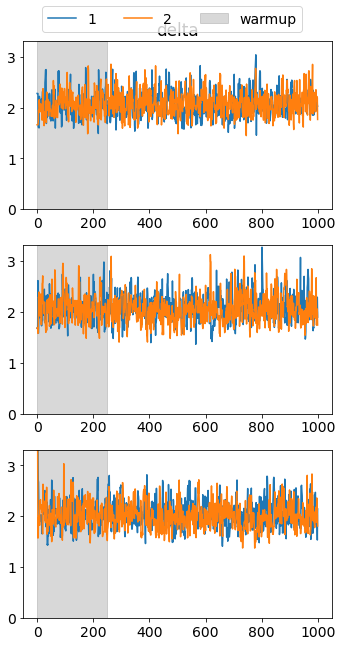

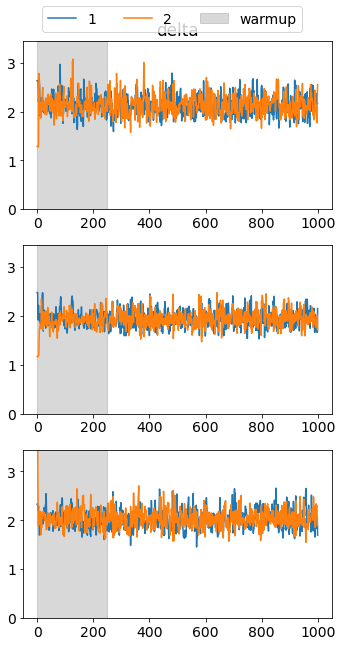

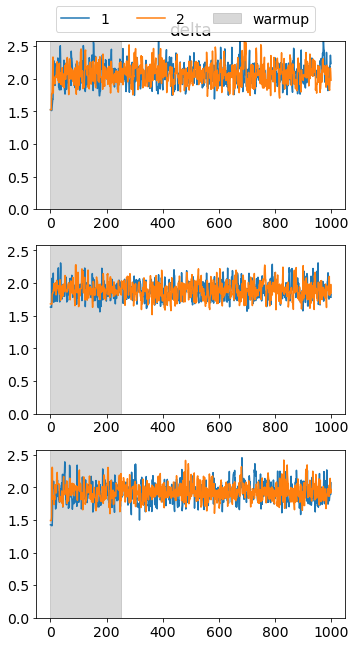

In [35]:
for i in range(3):
    trace_plots(fits_list[i], ['delta'], warmup=warmup)

C:\Users\ethan\AppData\Local\Temp\ipykernel_21780\1073285458.py:32: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  axs[i, j].set_xlim(0, max_x[j])


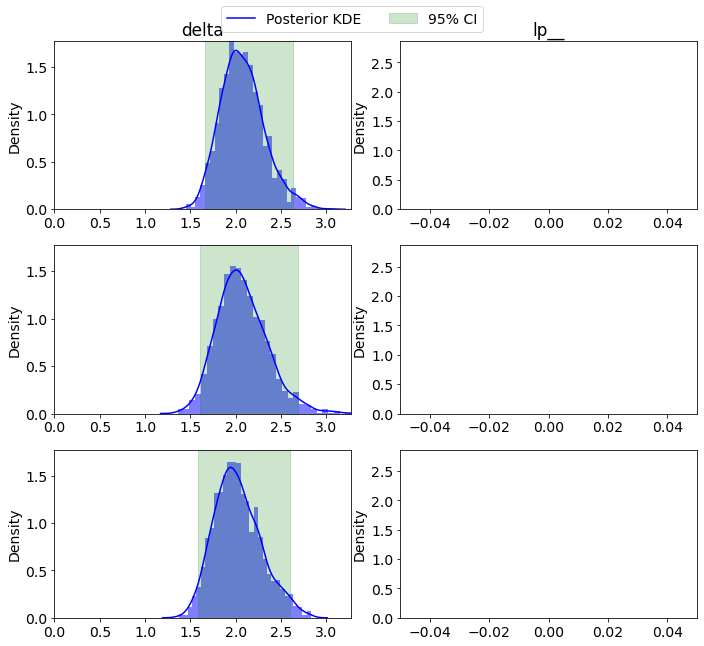

C:\Users\ethan\AppData\Local\Temp\ipykernel_21780\1073285458.py:32: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  axs[i, j].set_xlim(0, max_x[j])


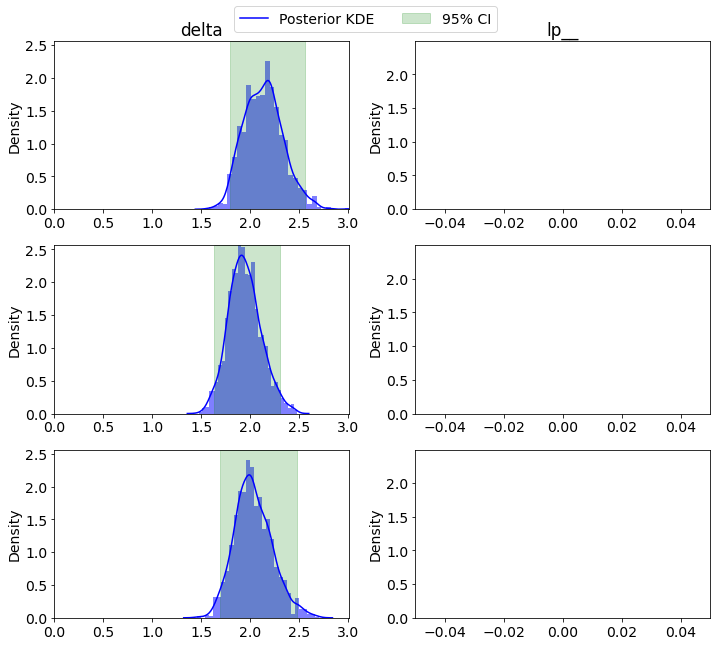

C:\Users\ethan\AppData\Local\Temp\ipykernel_21780\1073285458.py:32: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  axs[i, j].set_xlim(0, max_x[j])


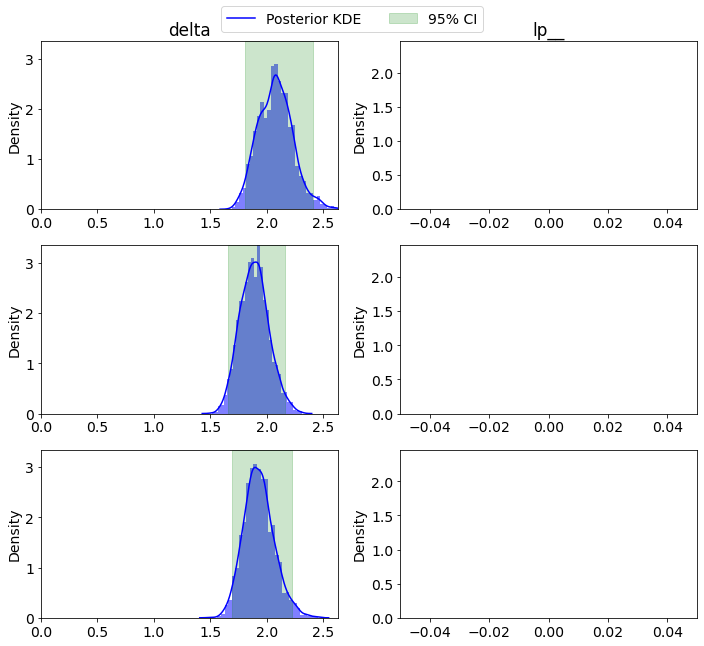

In [39]:
for i in range(3):
    posterior_histograms(fits_list[i], ['delta', 'lp__'])

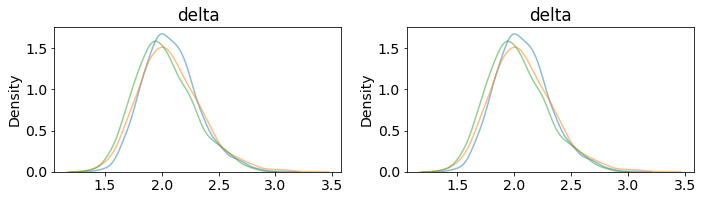

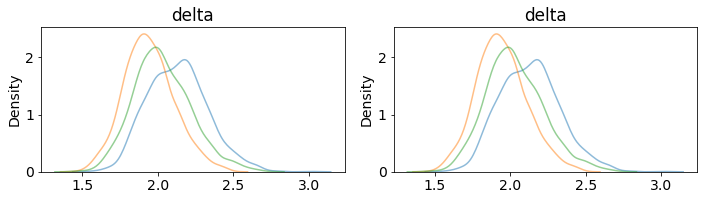

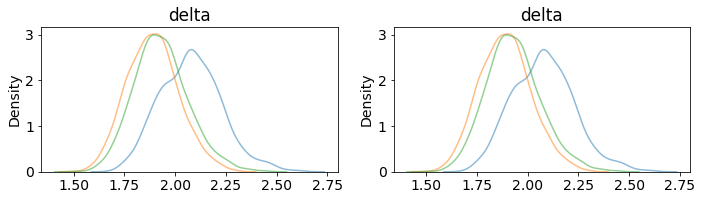

In [41]:
for i in range(3):
    posterior_kdes_overlaid(fits_list[i], ['delta', 'delta'])